CS 7643 Project

Georgia Institute of Technology

Author: Daniel Solon and Carmen Yu

# Improved Implementation: RoBERTa+BiLSTM

Using best parameters on the full training dataset with metadata, the performance metric scores on the test dataset are as follows:
1. Test Accuracy: 0.8378
2. F1 Score: 0.8335
3. MCC: 0.7034

With the metadata normalized, the new performance metric scores are as follows:
1. Test Accuracy: 0.8592
2. F1 Score: 0.8571
3. MCC: 0.7328

## Import Libraries

In [86]:
import os
import json
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, f1_score, matthews_corrcoef
from tqdm import tqdm
import itertools
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Visualization
import matplotlib.pyplot as plt
import joblib
from wordcloud import WordCloud, STOPWORDS
from collections import Counter
from sklearn.preprocessing import StandardScaler

## Set Device
Set device to CUDA if available, else CPU

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [16]:
if device == 'cuda':
    torch.cuda.empty_cache()

## Loading Data (Test, Train, Validate)

In [94]:
# User Metadata
train_metadata = torch.load("../Data/Processed_Data/train_metadata_tensor.pth").to(device)
test_metadata = torch.load("../Data/Processed_Data/test_metadata_tensor.pth").to(device)
# validate_metadata = torch.load("../Data/Processed_Data/validate_metadata_tensor.pth").to(device)

# Tweets Data
train_tweets = torch.load("../Data/Processed_Data/train_tweet_emb_tensor.pth").to(device)
test_tweets = torch.load("../Data/Processed_Data/test_tweet_emb_tensor.pth").to(device)
# validate_tweets = torch.load("../Data/Processed_Data/validate_tweet_roberta_emb_tensor.pth").to(device)

# Labels
train_labels = torch.load("../Data/Processed_Data/train_label_tensor.pth").to(device)
test_labels = torch.load("../Data/Processed_Data/test_label_tensor.pth").to(device)
# validate_labels = torch.load("../Data/Processed_Data/validate_label_tensor.pth").to(device)

In [12]:
print(train_tweets.shape)
print(test_tweets.shape)
# print(validate_tweets.shape)

print(train_metadata.shape)
print(test_metadata.shape)
# print(validate_metadata.shape)

torch.Size([1398465, 200])
torch.Size([199863, 200])
torch.Size([1398465, 5])
torch.Size([199863, 5])


In [14]:
# Convert to NumPy
train_metadata_np = train_metadata[:,:-1].cpu().numpy()

# Fit the scaler
scaler = StandardScaler()
scaler.fit(train_metadata_np)

# Extract mean and variance
mean = scaler.mean_
std = scaler.scale_

print("mean:", mean)
print("std:", std)

mean: [763133.67226781   7599.98017612  15554.84789609   1774.92554265]
std: [4501500.41679737   69059.40337382   43503.65654065   10696.40439349]


Set seed for Reproducibility

In [19]:
seed = 42
torch.manual_seed(seed)


## BiLSTM Model

In [20]:
class LSTMModel(nn.Module):

    def __init__(self, input_size, hidden_size, output_size, num_layers=1, dropout_rate = 0.0):
        super(LSTMModel, self).__init__()

        # Define the LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional = True, dropout = dropout_rate)

        # Define a fully connected output layer
        self.fc = nn.Linear(hidden_size * 2, output_size)


    def forward(self, x):
        # Pass through BiLSTM
        lstm_out, (hn, cn) = self.lstm(x)

        output = self.fc(lstm_out[:, -1, :])
        return output

In [21]:
lstm_input_size = 200
lstm_hidden_size = 128
lstm_output_size = 64
lstm_number_layers = 1 # Number of LSTM Layers
lstm_dropout = 0

In [22]:
# Creating LSTM Model
lstm_model = LSTMModel(input_size = lstm_input_size, hidden_size = lstm_hidden_size, output_size = lstm_output_size,
                      num_layers = lstm_number_layers, dropout_rate=lstm_dropout).to(device)

## Prepare Data

Getting lstm_output for datasets

In [100]:
train_tweets = train_tweets.unsqueeze(1).to(torch.float32)
test_tweets = test_tweets.unsqueeze(1).to(torch.float32)

In [101]:
train_lstm_output = lstm_model(train_tweets)
train_lstm_output = train_lstm_output.detach()

test_lstm_output = lstm_model(test_tweets)
test_lstm_output = test_lstm_output.detach()

OutOfMemoryError: CUDA out of memory. Tried to allocate 33.08 GiB. GPU 0 has a total capacity of 15.99 GiB of which 2.62 GiB is free. Of the allocated memory 11.09 GiB is allocated by PyTorch, and 114.89 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [102]:
print(train_lstm_output.shape)
print(test_lstm_output.shape)

torch.Size([1398465, 128])
torch.Size([199863, 128])


Normalize Metadata

In [103]:
def normalize_training_metadata(tensor):
    scaler = StandardScaler()
    data = tensor.cpu().numpy()
    data[:,-5:-1] = scaler.fit_transform(data[:,-5:-1])
    normalized_tensor = torch.tensor(data, dtype=torch.float32).to(device)
    return normalized_tensor, scaler

def normalize_tensor(scaler, tensor):
    data = tensor.cpu().numpy()
    data[:,-5:-1] = scaler.transform(data[:,-5:-1])
    normalized_tensor = torch.tensor(data, dtype=torch.float32).to(device)
    return normalized_tensor

In [ ]:
train_metadata, scaler = normalize_training_metadata(train_metadata)
test_metadata = normalize_tensor(scaler, test_metadata)

# Save the scaler to use for future normalization
joblib.dump(scaler, '../Data/Models/scaler.pkl')

array([4501500.41679737,   69059.40337382,   43503.65654065,
         10696.40439349])

Concatenate text embedding with metadata embedding

In [ ]:
x_train = torch.hstack((train_lstm_output, train_metadata)).to(torch.float32)
x_test = torch.hstack((test_lstm_output, test_metadata)).to(torch.float32)

In [ ]:
y_train = train_labels.view(-1, 1).to(torch.float32)
y_test = test_labels.view(-1, 1).to(torch.float32)

In [ ]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

In [ ]:
x_train.requires_grad_(False)
y_train.requires_grad_(False)

## DenseNet
Define Dense Classifier Model. The layers are as defined on the paper: Input Layer, Hidden Layer, then Output Layer. Model parameters are based on Table 2 from the paper. However, some parameter values might not match because of description ambiguity.

In [104]:
class DenseBotClassifier(nn.Module):
    
    def __init__(self, input_dim=37, output_dim=1, hidden_input_dim=128, hidden_dim=512, hidden_output_dim=64, dropout=0.2):
        """
        :param input_dim: (RoBERTa embeddings + metadata) dimension
        :param output_dim: 1 for binary classification
        :param input_dim: input_layer input dimension
        :param output_dim: input_layer output dimension
        :param hidden_input_dim: hidden_layer input dimension
        :param hidden_dim: hidden_layer intermediate dimension
        :param hidden_output_dim: hidden_layer output dimension
        :param dropout: adjust for hyperparameter tuning
        """
        super(DenseBotClassifier, self).__init__()

        self.input_layer = nn.Sequential(
                            nn.Linear(input_dim, hidden_input_dim),
                            nn.BatchNorm1d(hidden_input_dim),
                            nn.SELU(),
                            nn.Dropout(dropout)
                        )

        self.hidden_layer = nn.Sequential(
                            nn.Linear(hidden_input_dim, hidden_dim),
                            nn.BatchNorm1d(hidden_dim),
                            nn.SELU(),
                            nn.Linear(hidden_dim, hidden_output_dim),
                            nn.BatchNorm1d(hidden_output_dim),
                            nn.SELU(),
                            nn.Dropout(dropout)
                        )

        self.output_layer = nn.Linear(hidden_output_dim, output_dim)


    def forward(self, x):
        input_layer_activation = self.input_layer(x)
        hidden_layer_activation = self.hidden_layer(input_layer_activation)

        return self.output_layer(hidden_layer_activation)

## Create Dataloaders

In [105]:
batch_size = 128 # Batch size for training

train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(x_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

## Model Training

Initialize model, loss function, and optimizer

In [106]:
torch.manual_seed(seed)
model = DenseBotClassifier().to(device)
criterion = nn.BCEWithLogitsLoss()  # Binary Cross Entropy with logits
optimizer = optim.Adam(model.parameters(), lr=0.005)

Train model

In [107]:
def train_model(model, train_loader, optimizer, criterion, epochs=10):
    """
    :param model: bot classifier
    :param train_loader: training dataset
    :param optimizer: Adam as specified on paper
    :param criterion: BCE as specified on paper
    :param epochs: adjust for hyperparameter tuning
    :return: None
    """
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=True, dynamic_ncols=True, position=0)

        for i, batch in enumerate(progress_bar):
            embeddings, labels = batch[0].float().to(device), batch[1].float().to(device)
            optimizer.zero_grad()
            outputs = model(embeddings)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            if i % 10 == 0:
                progress_bar.set_postfix(loss=f"{loss.item():.4f}")

In [ ]:
train_model(model, train_loader, optimizer, criterion, epochs=10)

## Model Evaluation

Evaluate model

In [108]:
def evaluate_model(model, test_loader):
    """
    :param model: bot classifier
    :param test_loader: testing dataset
    :return: None
    """
    model.eval()
    preds, true_labels = [], []

    with torch.no_grad():
        progress_bar = tqdm(test_loader, desc="Evaluating", unit="batch", dynamic_ncols=True, position=0)
        all_probs = []

        for batch in progress_bar:
            embeddings, labels = batch[0].float().to(device), batch[1].float().to(device)
            outputs = model(embeddings)
            probs = torch.sigmoid(outputs)
            all_probs.append(probs.cpu().numpy())
            preds.extend((probs > 0.5).cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(true_labels, preds)
    f1 = f1_score(true_labels, preds, average='weighted')  # Adjust 'weighted' if needed
    mcc = matthews_corrcoef(true_labels, preds)

    return acc, f1, mcc, all_probs

In [ ]:
evaluate_model(model, test_loader)

## WordCloud

In [109]:
def create_wordcloud(probs):
    with open('../Data/test.json', 'r') as file:
        data = json.load(file)
    
    # flatten the JSON using json_normalize
    flattened_data = pd.json_normalize(data)

    # convert the flattened data into a Pandas DataFrame
    df_raw = pd.DataFrame(flattened_data)

    # explode the tweets column to separate each tweet into its own row
    df_explode_tweets = df_raw.explode('tweet').copy()

    # add the probabilities to the dataframe
    df_explode_tweets['prob'] = probs.tolist()

    # Combine tweet text into one big string
    bot_text = " ".join([str(t) for t in df_explode_tweets[df_explode_tweets['prob'] >= 0.5]['tweet'].tolist() if t is not None])
    non_bot_text = " ".join([str(t) for t in df_explode_tweets[df_explode_tweets['prob'] < 0.5]['tweet'].tolist() if t is not None])

    # make stopwords
    stopwords = set(STOPWORDS)
    stopwords.update([
        "rt", "https", "co", "amp", "t.co", "the", "and", "is", "to", "in", "for", "of", "t", 
        "I", "a", "that", "this", "it", "on", "you", "with", "as", "at", "are", "be", "by", "an", 
        "not", "or", "The", "&amp;", "de", "la", "que", "el", "en", "y", "a", "los", "del", "se", "las",
        "por", "un", "para", "con", "no", "una", "su", "al", "lo", "como", "it's",
        "más", "pero", "sus", "le", "ya", "o", "este", "sí", "porque", "esta", "-", "this", "so", "just",
        "what", "all", "if", "we", "my", "your", "they", "their", "them", "he", "she", "his", "her"
    ])

    # Create word clouds
    bot_wc = WordCloud(width=800, height=400, background_color='black', colormap='Blues', stopwords= stopwords).generate(bot_text)
    non_bot_wc = WordCloud(width=800, height=400, background_color='black', colormap='Greens', stopwords= stopwords).generate(non_bot_text)


    bot_text_split = bot_text.lower().split()
    non_bot_text_split = non_bot_text.lower().split()
    bot_text_split = [word for word in bot_text_split if word not in stopwords]
    non_bot_text_split = [word for word in non_bot_text_split if word not in stopwords]

    bot_word_frequencies = Counter(bot_text_split)
    non_bot_word_frequencies = Counter(non_bot_text_split)

    # Get the most common words for the histogram
    bot_most_common_words = bot_word_frequencies.most_common(10)  
    non_bot_most_common_words = non_bot_word_frequencies.most_common(10) 

    bot_words, bot_frequencies = zip(*bot_most_common_words)
    non_bot_words, non_bot_frequencies = zip(*non_bot_most_common_words)

    # Plot
    fig, ax = plt.subplots(2, 2, figsize=(16, 8))
    ax[0][0].imshow(bot_wc, interpolation='bilinear')
    ax[0][0].set_title('Bot Tweets', fontsize=16)
    ax[0][0].axis('off')

    ax[0][1].imshow(non_bot_wc, interpolation='bilinear')
    ax[0][1].set_title('Non-Bot Tweets', fontsize=16)
    ax[0][1].axis('off')

    ax[1][0].barh(bot_words[::-1], bot_frequencies[::-1], color='skyblue', edgecolor='black')
    ax[1][0].set_xlabel('Frequency')
    ax[1][0].set_title("Histogram", fontsize=16)

    ax[1][1].barh(non_bot_words[::-1], non_bot_frequencies[::-1], color='green', edgecolor='black')
    ax[1][1].set_xlabel('Frequency')
    ax[1][1].set_title("Histogram", fontsize=16)


    plt.show()

    plt.savefig('../Images/bilstm_dense_wordcloud.png', dpi=300, bbox_inches='tight')

## Grid search

Batch data fed to LSTM to fit in GPU

In [110]:
def extract_lstm_outputs(model, dataloader):
    model.eval()
    outputs = []
    with torch.no_grad():
        for (batch,) in dataloader:
            batch = batch.to(device)
            out = model(batch)
            outputs.append(out.cpu())
    return torch.cat(outputs, dim=0)

Define parameter grid

In [111]:
param_grid = {
    "learning_rate": [0.0005],
    "lstm_dropout": [0],
    "lstm_hidden_size": [128],
    "lstm_output_size": [128],
    "lstm_number_layers": [1],
    "batch_size": [64],
    "dropout": [0],
    "hidden_input_dim": [128],
    "hidden_dim": [64],
    "hidden_output_dim": [32],
    "epochs": [10],
    "weight_decay": [0]
}

# Generate all combinations
param_combinations = list(itertools.product(*param_grid.values()))

Run grid search and save results

In [112]:
# Define CSV file path
csv_filename = "../Data/Tuning_Results/hyperparameter_results_BiLSTM_DenseNet.csv"

# Load existing results if the CSV exists
if os.path.exists(csv_filename):
    existing_results = pd.read_csv(csv_filename)
else:
    existing_results = pd.DataFrame(columns=["learning_rate", "lstm_dropout", "lstm_hidden_size", "lstm_output_size", "lstm_number_layers", "batch_size", "dropout", "hidden_input_dim", "hidden_dim", "hidden_output_dim", "epochs", "weight_decay", "accuracy", "f1_score", "mcc"])

# Convert existing results to a set of tested hyperparameters
tested_params = set(
    tuple(row) for row in existing_results[["learning_rate", "lstm_dropout", "lstm_hidden_size", "lstm_output_size", "lstm_number_layers", "batch_size", "dropout", "hidden_input_dim", "hidden_dim", "hidden_output_dim", "epochs", "weight_decay"]].values
)

# Filter out already tested hyperparameters
new_param_combinations = param_combinations#[params for params in param_combinations if params not in tested_params]

print(f"Total hyperparameter sets to test: {len(new_param_combinations)}")

torch.manual_seed(seed)


# Loop through only new hyperparameter combinations
for i, params in enumerate(new_param_combinations):
    print("-----------------------------------------------------------------------------------------------------")
    print(f"Processing parameters {i+1}/{len(new_param_combinations)}")

    lr, lstm_dropout, lstm_hidden_size, lstm_output_size, lstm_number_layers, batch_size, dropout, hidden_input, hidden, hidden_output, epochs, weight_decay = params

    # Initialize lstm model
    lstm_model = LSTMModel(
                    input_size = lstm_input_size,
                    hidden_size = lstm_hidden_size,
                    output_size = lstm_output_size,
                    num_layers = lstm_number_layers,
                    dropout_rate = lstm_dropout
                ).to(device)

    lstm_train_dataset = TensorDataset(train_tweets)
    lstm_train_loader = DataLoader(lstm_train_dataset, batch_size=batch_size, shuffle=False)

    lstm_test_dataset = TensorDataset(test_tweets)
    lstm_test_loader = DataLoader(lstm_test_dataset, batch_size=batch_size, shuffle=False)

    train_lstm_output = extract_lstm_outputs(lstm_model, lstm_train_loader).detach()
    test_lstm_output = extract_lstm_outputs(lstm_model, lstm_test_loader).detach()

    # save model checkpoint
    torch.save(lstm_model.state_dict(), f"../Data/Models/Glove_LSTM_DenseNet_BiLSTM_model.pth")

    x_train = torch.hstack((train_lstm_output.to(device), train_metadata)).to(torch.float32)
    x_test = torch.hstack((test_lstm_output.to(device), test_metadata)).to(torch.float32)

    y_train = train_labels.view(-1, 1).to(torch.float32)
    y_test = test_labels.view(-1, 1).to(torch.float32)

    x_train.requires_grad_(False)
    y_train.requires_grad_(False)

    # Initialize neural network model
    model = DenseBotClassifier(
        input_dim=x_train.shape[1],
        output_dim=1,
        hidden_input_dim=hidden_input,
        hidden_dim=hidden,
        hidden_output_dim=hidden_output,
        dropout=dropout
    ).to(device)

    # Define loss and optimizer
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    # Create Data Loaders
    train_dataset = TensorDataset(x_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

    test_dataset = TensorDataset(x_test, y_test)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

    # Train the model
    train_model(model, train_loader, optimizer, criterion, epochs=epochs)

    # Evaluate the model
    acc, f1, mcc, all_probs = evaluate_model(model, test_loader)

    # Save model checkpoint
    torch.save(model.state_dict(), f"../Data/Models/Glove_LSTM_DenseNet_Dense_model.pth")

    # Save results
    df_new = pd.DataFrame([{
        "learning_rate": lr,
        "lstm_dropout": lstm_dropout,
        "lstm_hidden_size": lstm_hidden_size,
        "lstm_output_size": lstm_output_size,
        "lstm_number_layers": lstm_number_layers,
        "batch_size": batch_size,
        "dropout": dropout,
        "hidden_input_dim": hidden_input,
        "hidden_dim": hidden,
        "hidden_output_dim": hidden_output,
        "epochs": epochs,
        "weight_decay": weight_decay,
        "accuracy": acc,
        "f1_score": f1,
        "mcc": mcc
    }])

    df_new.to_csv(csv_filename, mode='a', header=not os.path.exists(csv_filename), index=False)

print("Grid search complete. Results saved to hyperparameter_results_BiLSTM_DenseNet.csv.")

Total hyperparameter sets to test: 1
-----------------------------------------------------------------------------------------------------
Processing parameters 1/1


Evaluating: 100%|██████████| 3123/3123 [00:02<00:00, 1113.73batch/s]


Grid search complete. Results saved to hyperparameter_results_BiLSTM_DenseNet.csv.


C:\Users\Carmen\AppData\Local\Temp\ipykernel_4780\662527680.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  all_probs = torch.cat([torch.tensor(p) for p in all_probs], dim=0)


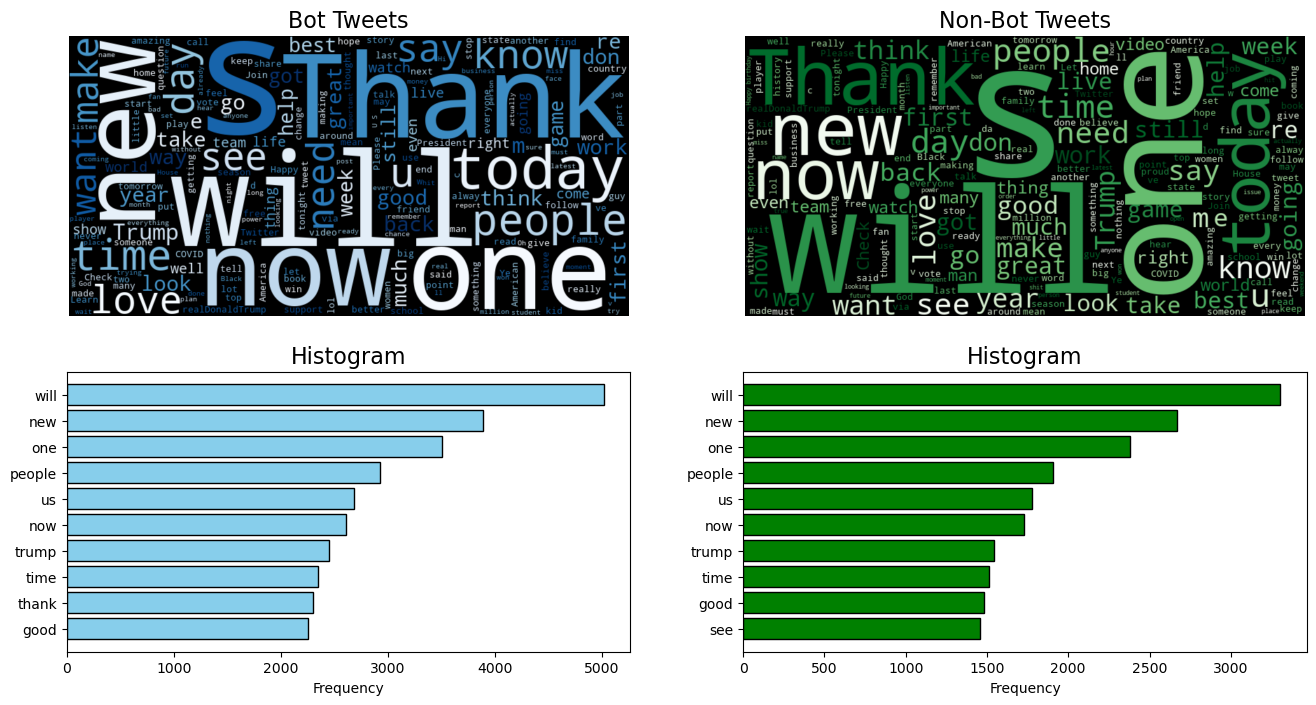

<Figure size 640x480 with 0 Axes>

In [114]:
all_probs = torch.cat([torch.tensor(p) for p in all_probs], dim=0)
create_wordcloud(all_probs)